In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np

In [2]:
import random

def set_seed(seed=777):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(777)

In [3]:
!pip install torchvision 

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image

class RoomsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
from torch.utils.data import DataLoader

train_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/train',
    transform=train_transforms
)

val_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/val',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
import torchvision.models as models


class RoomClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=4, freeze_backbone=True):
        super().__init__()

        # Load pretrained MobileNetV2
        self.base_model = models.mobilenet_v2(weights="IMAGENET1K_V1")

        # Freeze backbone if needed
        if freeze_backbone:
            for param in self.base_model.features.parameters():
                param.requires_grad = False

        # Replace classifier
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
import os

train_dir = "../../splitted_dataset/train"

class_names = sorted(os.listdir(train_dir))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

labels = []
for cls in class_names:
    labels += [class_to_idx[cls]] * len(os.listdir(f"{train_dir}/{cls}"))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

Class weights: tensor([1.0925, 0.6295, 1.3696, 1.3056])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RoomClassifierMobileNet(num_classes=4)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4
)

In [10]:
# Training loop
num_epochs = 50
best_val_acc = 0
no_improve_in_a_row = 0

for epoch in range(num_epochs):
    if no_improve_in_a_row >= 5:
        print("Hardstop because no improvements")
        break
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_name = f"best_model_epoch_{epoch + 1}.pth"
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc
        }, best_model_name)

        no_improve_in_a_row = 0

        print(f"✅ New best model saved (Val Acc: {val_acc:.4f})")
    else:
        no_improve_in_a_row += 1

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

✅ New best model saved (Val Acc: 0.4889)
Epoch 1/50
  Train Loss: 1.3678, Train Acc: 0.3388
  Val Loss: 1.2342, Val Acc: 0.4889
✅ New best model saved (Val Acc: 0.5904)
Epoch 2/50
  Train Loss: 1.1896, Train Acc: 0.5197
  Val Loss: 1.0775, Val Acc: 0.5904
✅ New best model saved (Val Acc: 0.6568)
Epoch 3/50
  Train Loss: 1.0543, Train Acc: 0.6286
  Val Loss: 0.9838, Val Acc: 0.6568
Hardstop because no improvements
Epoch 4/50
  Train Loss: 0.9716, Train Acc: 0.6602
  Val Loss: 0.9307, Val Acc: 0.6365
✅ New best model saved (Val Acc: 0.7214)
Epoch 5/50
  Train Loss: 0.8965, Train Acc: 0.6607
  Val Loss: 0.8204, Val Acc: 0.7214
Hardstop because no improvements
Epoch 6/50
  Train Loss: 0.8698, Train Acc: 0.6928
  Val Loss: 0.7943, Val Acc: 0.7159
✅ New best model saved (Val Acc: 0.7251)
Epoch 7/50
  Train Loss: 0.8229, Train Acc: 0.6954
  Val Loss: 0.7659, Val Acc: 0.7251
✅ New best model saved (Val Acc: 0.7417)
Epoch 8/50
  Train Loss: 0.7722, Train Acc: 0.7322
  Val Loss: 0.7275, Val Acc:

In [11]:
model = RoomClassifierMobileNet(num_classes=4) 

checkpoint = torch.load(best_model_name, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

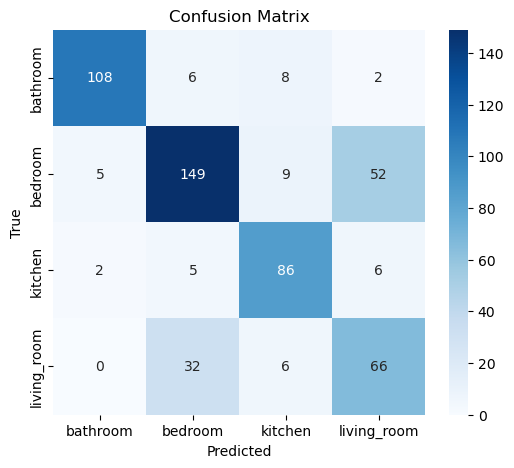

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names
))

              precision    recall  f1-score   support

    bathroom       0.94      0.87      0.90       124
     bedroom       0.78      0.69      0.73       215
     kitchen       0.79      0.87      0.83        99
 living_room       0.52      0.63      0.57       104

    accuracy                           0.75       542
   macro avg       0.76      0.77      0.76       542
weighted avg       0.77      0.75      0.76       542



In [15]:
for param in model.base_model.features[-4:].parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
    {'params': model.base_model.features[-4:].parameters(), 'lr': 1e-4},
    {'params': model.base_model.classifier.parameters(), 'lr': 1e-3} 
])

num_epochs = 10

In [16]:
best_val_acc = 0.7565

In [17]:
for epoch in range(num_epochs):

    # ===== TRAIN =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # ===== SAVE BEST MODEL =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc
        }, "best_model.pth")

        print(f"✅ New best model saved (Val Acc: {val_acc:.4f})")

    print(f"""
Epoch {epoch+1}/{num_epochs}
Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}
Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}
""")

✅ New best model saved (Val Acc: 0.8063)

Epoch 1/10
Train Loss: 0.6166, Train Acc: 0.7407
Val Loss:   0.4577, Val Acc:   0.8063


Epoch 2/10
Train Loss: 0.3667, Train Acc: 0.8585
Val Loss:   0.4556, Val Acc:   0.7915


Epoch 3/10
Train Loss: 0.2258, Train Acc: 0.9185
Val Loss:   0.5233, Val Acc:   0.7731

✅ New best model saved (Val Acc: 0.8100)

Epoch 4/10
Train Loss: 0.1683, Train Acc: 0.9363
Val Loss:   0.4765, Val Acc:   0.8100


Epoch 5/10
Train Loss: 0.0979, Train Acc: 0.9642
Val Loss:   0.5504, Val Acc:   0.7989

✅ New best model saved (Val Acc: 0.8229)

Epoch 6/10
Train Loss: 0.0930, Train Acc: 0.9648
Val Loss:   0.6203, Val Acc:   0.8229


Epoch 7/10
Train Loss: 0.0499, Train Acc: 0.9837
Val Loss:   0.5796, Val Acc:   0.8137


Epoch 8/10
Train Loss: 0.0440, Train Acc: 0.9847
Val Loss:   0.6016, Val Acc:   0.8173

✅ New best model saved (Val Acc: 0.8266)

Epoch 9/10
Train Loss: 0.0268, Train Acc: 0.9916
Val Loss:   0.5940, Val Acc:   0.8266

✅ New best model saved (Val Acc: 0.

In [18]:
!pip install onnxscript

In [19]:
model = RoomClassifierMobileNet(num_classes=4) 

checkpoint = torch.load("best_model.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

dummy_input = torch.randn(1, 3, 224, 224)
onnx_path = "roomg_classifier_mobilenet_v2_tunned.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("Model successfully exported to roomg_classifier_mobilenet_v2_tunned.onnx")

/var/folders/pd/fx9stk756697jx8_ft4b76080000gp/T/ipykernel_38041/3428983276.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `RoomClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `RoomClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.
Model successfully exported to roomg_classifier_mobilenet_v2_tunned.onnx


Launch on test folder of dataset

In [20]:
model = RoomClassifierMobileNet(num_classes=4)
checkpoint = torch.load("best_model.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

RoomClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96,

In [21]:
test_dataset = RoomsDataset(
    data_dir='../../splitted_dataset/test',
    transform=val_transforms
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [23]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8509


In [24]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=test_dataset.classes
))

              precision    recall  f1-score   support

    bathroom       0.97      0.92      0.94        63
     bedroom       0.84      0.83      0.84       109
     kitchen       0.91      0.96      0.93        50
 living_room       0.69      0.70      0.69        53

    accuracy                           0.85       275
   macro avg       0.85      0.85      0.85       275
weighted avg       0.85      0.85      0.85       275



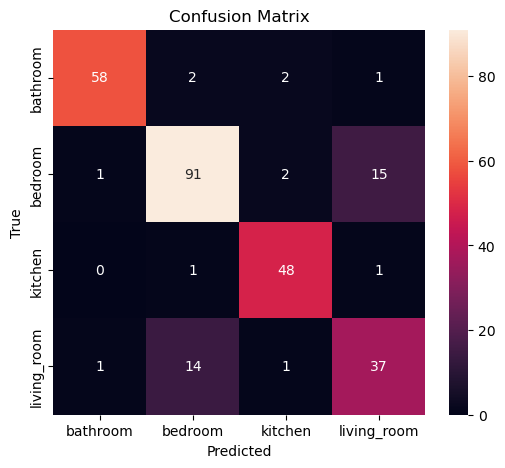

In [25]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [26]:
best_val_acc

0.8284132841328413